In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!unzip -qn '/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/yolo_plate_dataset.zip'

In [2]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class PlateDetectionDataset(Dataset):
  def __init__(self, images_folder, labels_folder, transform=None):
    super(PlateDetectionDataset, self).__init__()

    self.images_folder = images_folder
    self.labels_folder = labels_folder
    self.transform = transform

    self.image_files = sorted(os.listdir(self.images_folder))

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    image_file = self.image_files[index]
    label_file = os.path.join(self.labels_folder, image_file[:-4] + '.txt')

    image = Image.open(os.path.join(self.images_folder, image_file))
    image_width, image_height = image.size

    image = np.array(image, dtype='float32') / 255.0
    target = self.get_target(label_file, image_width, image_height)

    if self.transform:
      augmented = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
      image = augmented['image']
      target['boxes'] = torch.tensor(augmented['bboxes'], dtype=torch.float)
      target['labels'] = torch.tensor(augmented['labels'])

    return image, target

  def xywh_to_xyxy(self, box, image_width, image_height):
    category = int(box[0])

    x1 = int((float(box[1]) - float(box[3])/2)* image_width)
    y1 = int((float(box[2]) - float(box[4])/2) *image_height)
    x2 = x1 + int(float(box[3]) * image_width)
    y2 = y1 + int(float(box[4]) * image_height)

    # x1 = float(box[1]) - float(box[3])/2
    # y1 = float(box[2]) - float(box[4])/2
    # x2 = x1 + float(box[3])
    # y2 = y1 + float(box[4])

    return [category, x1, y1, x2, y2]

  def get_target(self, label_file, image_width, image_height):
    with open(os.path.join(self.labels_folder, label_file), 'r') as f:
      boxes = f.readlines()

    target = {}
    labels = []
    bboxes = []

    for box in boxes:
      box = box[:-2].split()
      box = self.xywh_to_xyxy(box, image_width, image_height)
      labels.append(box[0] + 1) #for resnet50 classes start with 1, not 0
      bboxes.append(box[1:])

    if len(bboxes) == 0:
      bboxes.append([0, 0, image_width,image_height])
      labels.append(0)
    target['boxes'] = bboxes
    target['labels'] = labels

    return target

In [6]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [7]:
train_transform = A.Compose(
    [
      # A.Resize(height=224, width=224),
      A.HorizontalFlip(p=0.5),
      A.Rotate(limit=15, p=0.5),
      # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
      ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
    )
)

val_transform = A.Compose(
    [
        # A.Resize(height=224, width=224),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
    )
)

In [8]:
df_train = PlateDetectionDataset('/content/yolo_plate_dataset/images/train', '/content/yolo_plate_dataset/labels/train', transform=train_transform)
df_val = PlateDetectionDataset('/content/yolo_plate_dataset/images/val', '/content/yolo_plate_dataset/labels/val', transform=val_transform)
df_test = PlateDetectionDataset('/content/yolo_plate_dataset/images/test', '/content/yolo_plate_dataset/labels/test', transform=val_transform)

train_loader = DataLoader(df_train, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(df_val, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(df_test, batch_size=8, shuffle=False, collate_fn=collate_fn)

FileNotFoundError: [Errno 2] No such file or directory: '/content/yolo_plate_dataset/images/train'

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN, fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
  model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [ ]:
#1) Let's get the model with the changed box predictor
#2) let's freeze all the layers except for the last one

model = get_model(2)
for name, param in model.named_parameters():
  if 'box_predictor' not in name:
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 146MB/s]


In [ ]:
def train_one_epoch(model, loader, device, optimizer, scheduler=None):
  model.train()

  train_loss = 0.0
  for images, labels in tqdm(loader):
    images = [image.to(device) for image in images]
    labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

    losses = model(images, labels)
    loss = sum(losses.values())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if scheduler:
      scheduler.step()

    train_loss += loss.item()

  train_loss /= len(loader)
  return train_loss


In [ ]:
def apply_nms(preds, score_threshold, iou_threshold):
  for pred in preds:
    boxes, scores, labels = pred['boxes'], pred['scores'], pred['labels']
    indices = torch.nonzero(scores > score_threshold).squeeze(1)
    boxes = boxes[indices]
    scores = scores[indices]
    labels = labels[indices]

    indices = torchvision.ops.nms(boxes, scores, iou_threshold)
    pred['boxes'] = boxes[indices]
    pred['scores'] = scores[indices]
    pred['labels'] = labels[indices]
  return preds

def test_one_epoch(model, loader, device, score_threshold, iou_threshold):
  model.eval()
  metric = MeanAveragePrecision(iou_type='bbox')

  for images, labels in tqdm(loader):
    images = [image.to(device) for image in images]
    labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

    with torch.no_grad():
      preds = model(images)
      print('preds before nms', preds)
      preds = apply_nms(preds, score_threshold, iou_threshold)
      print('preds after nms', preds)
      metric.update(preds, labels)

  metric.compute()
  return metric


In [ ]:
def train(num_epochs, model, train_loader, val_loader, device, optimizer, frozen_layers=True, scheduler=None):
  train_losses = []
  metric_values = []
  score_threshold = 0.7
  iou_threshold = 0.5

  for epoch in range(num_epochs):

    print(f'epoch: {epoch}')

    train_loss = train_one_epoch(model, train_loader, device, optimizer, scheduler)
    metric_value = test_one_epoch(model, val_loader, device, score_threshold, iou_threshold)
    train_losses.append(train_loss)
    metric_values.append(metric_value)
    print(f'train loss: {train_loss}')

    if len(train_losses) > 2 and train_losses[-1] > train_losses[-3]:
      print(f'Early stopping at epoch {epoch}')
      if frozen_layers:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/frozen_att1_epoch{epoch}.pt')
      else:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/att1_epoch{epoch}.pt')
      return train_losses, metric_values

    if epoch % 5 == 4:
      print(f'Saving model')
      if frozen_layers:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/frozen_att1_epoch{epoch}.pt')
      else:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/att1_epoch{epoch}.pt')

  return train_losses, metric_values

In [ ]:
#just testing fine tuned model)

In [ ]:
def plot_losses(train_losses, layers_frozen=True):
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Training Loss Over Epochs, with frozen layers: {layers_frozen}')
  plt.legend()
  plt.show()

In [ ]:
from torchvision.utils import draw_bounding_boxes
def plot_image_boxes(images, outputs):
  outputs = apply_nms(outputs, 0.7, 0.5)
  fig, ax = plt.subplots(4, 2, figsize=(15, 20))

  for i in range(4):
    image0 = (images[2*i]*255).to(torch.uint8).cpu()
    image1 = (images[2*i+1]*255).to(torch.uint8).cpu()
    boxes0 = (outputs[2*i]['boxes']).to(torch.int).cpu()
    boxes1 = (outputs[2*i+1]['boxes']).to(torch.int).cpu()
    labels0 = outputs[2*i]['labels'].cpu().numpy().astype(str)
    labels1 = outputs[2*i+1]['labels'].cpu().numpy().astype(str)

    ax[i, 0].imshow(draw_bounding_boxes(image0, boxes0, labels0, colors='red').permute(1, 2, 0))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(draw_bounding_boxes(image1, boxes1, labels1, colors='red').permute(1, 2, 0))
    ax[i, 1].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)
NUM_EPOCHS = 10

In [ ]:
train_losses_frozen, metric_values_frozen = train(NUM_EPOCHS, model, train_loader, val_loader, device, optimizer)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model_epoch4 = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/frozen_goodmodel_epoch4.pt')

In [ ]:
images, labels = next(iter(test_loader))
images = [image.to(device) for image in images]
labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

In [ ]:
model_epoch4.eval()
with torch.no_grad():
  preds = model_epoch4(images)

In [ ]:
preds

[{'boxes': tensor([[128.2524, 135.4627, 225.0327, 171.4592]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9391], device='cuda:0')},
 {'boxes': tensor([[272.0764, 280.6435, 415.9608, 303.0000],
          [277.5481, 227.6393, 405.0179, 281.7799],
          [ 80.6432,  97.5014, 136.9074, 161.6822],
          [ 93.3389,  83.2217, 118.8500, 106.4868],
          [261.0128, 246.8798, 426.4382, 297.1966]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.2021, 0.1203, 0.0886, 0.0586, 0.0508], device='cuda:0')},
 {'boxes': tensor([[147.5811,  68.1255, 250.1377, 107.4861]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.0875], device='cuda:0')},
 {'boxes': tensor([[196.3072, 243.8271, 303.1974, 276.9234],
          [161.9247, 239.7933, 292.5233, 291.2362],
          [ 53.2900,  66.0729,  76.9238,  90.7095],
          [190.6307, 268.8006, 308.3370, 296.0206]], device='cuda:0'),
  

In [ ]:
preds = apply_nms(preds, 0.5, 0.5)

In [ ]:
plot_image_boxes(images, preds)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Now unfreeze all the layers, then fine-tune the model again with the lower LR

for param in model_epoch4.parameters():
  param.requires_grad = True

In [ ]:
optimizer = torch.optim.Adam(model_epoch4.parameters(), lr=0.00005)
NUM_EPOCHS = 10

train_losses, metric_values = train(NUM_EPOCHS, model_epoch4, train_loader, val_loader, device, optimizer, frozen_layers=False)

Output hidden; open in https://colab.research.google.com to view.

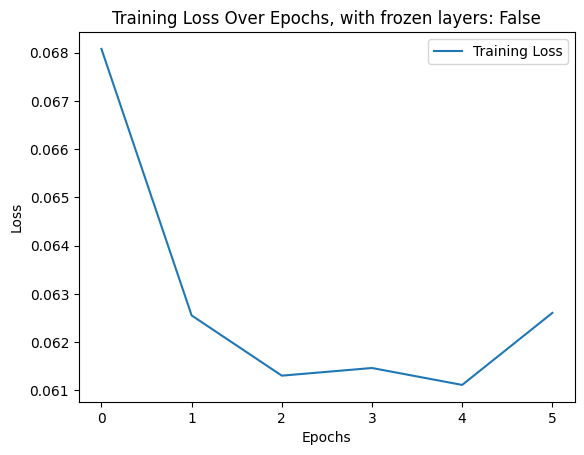

In [ ]:
plot_losses(train_losses, layers_frozen=False)

In [ ]:
metric_values[-1].compute()

{'map': tensor(0.6413),
 'map_50': tensor(0.9897),
 'map_75': tensor(0.7699),
 'map_small': tensor(0.5147),
 'map_medium': tensor(0.6723),
 'map_large': tensor(0.6602),
 'mar_1': tensor(0.6861),
 'mar_10': tensor(0.6953),
 'mar_100': tensor(0.6953),
 'mar_small': tensor(0.5838),
 'mar_medium': tensor(0.7223),
 'mar_large': tensor(0.7245),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}

In [ ]:
metric_values[-2].compute()

{'map': tensor(0.6695),
 'map_50': tensor(0.9897),
 'map_75': tensor(0.7965),
 'map_small': tensor(0.5513),
 'map_medium': tensor(0.6945),
 'map_large': tensor(0.6951),
 'mar_1': tensor(0.7055),
 'mar_10': tensor(0.7146),
 'mar_100': tensor(0.7146),
 'mar_small': tensor(0.6219),
 'mar_medium': tensor(0.7372),
 'mar_large': tensor(0.7358),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}